# Estimacion tiempo por vuelta de clasificación F1
## Memoria y codigo

En un principio teniamos un solo fichero excel en el que tenimos todos los datos iniciales de panel con los que ibamos atrabajar, al intentar cargar del excel la base de datos nos daba fallos en la funcion relaccionados con el propio excel y con el hecho de que fueran de panel, por lo que lo primero que hicimos fue pasarlo a un csv y cambiar la forma de importar los datos al  programa, luego surgieron otros probelemas con la formas de acceder a los datos, el hecho de utilizar eparadores distintos, los decimales con ',', lo cual fuimos solucionando con las distintos cambios en parametros en la llamada a funcion _read_csv_ (pese a eso al final lo arreglamos con la configuracion del excel y csv para no tener que utilizarlos) .

Una vez ya cargados los datos, los importaba en formato String (debido a usar ',' como separador en vez de '.', asi no lo reconocia como numero) por lo que no podia hacer calculos con estos y daba error, lo que solucionamos rapidamente transformandolos de string a float con la llamada a X.astype('float64').

Cuando empezamos a estimar el modelo nos dimos cuenta de los distintos problemas que podiamos tener, como era el de una multicolinealidad muy fuerte entre distintas variables de nuestra base de datos, con lo que empezamos a calcular los VIFS, matriz de correlaccion, etc... (explicado mas claramente en los distintos apartados).

Debido a todos estos cambios que fue sufriendo nuestro modelo de cambio en las variables, probamos con transformas algunas de ellas en log(), ir proponiendo nuevos modelos usando algunas variables y otras no, etc... para intentar reducir la multicolinealidad, comprobamos durante 2 semanas distintos conjunto de datos, hasta que nos dimos cuienta que el principal problema era la variable presupuesto (pese a ser la unica que realmente no tenia ninguna relaccion aparente con el resto) y ya hallamos el modelo que utilizamos finalmente (todos estos cambios fueron los que generaron todos los archivos excel y csv que tenemos en la carpeta datos).

El punto viene tambien en que para realizar estos cambios y probar con todas esas distintas combinaciones tuvimos que cambiar la forma en la que importabamos los datos a la matriz X, ya que al tratarse por columnas era muy complejo tener que dejar columnas entre medias son ser selccionadas. Esto lo solucionamos accediendo a los datos igual que en las practicas, para lo cual incluimos en la llamada a read_csv un parametro _"header = 0"_, con el que se incluye la primera fila del csv (donde aparece el nombre de cada variable), de esta forma accediendo luego con _"datos_f1.columns"_ a los nombres de las distintas variables podriamos coger las variables por sus nombres y no por las columnas.

In [151]:
import statsmodels.api as sm
import pandas as pd #librería para manejo de datos
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import numpy as np

datos_f1=pd.read_csv('datos/Datos F1_noMulti.csv', header=0)

datos_f1


,Tiempo Qualy (milisegundos),Length (m),Curva lenta,Curva media,Curva rapida,Presupuesto (mill. Euros),Asphalt Abrasion,log(aa),log(cl),log(cm),log(cr),log(ag),A�o,Race,procentaje de tiempo con el acelerador a fondo,porcentaje de tiempo de frenada,Downforce,Tyre Stress,Lateral energy,Asphalt Grip
0,83.485,5.303,6,4,5,429.5,3,0.477121,0.77815125,0.602060,0.698970,0.000000,2017,Australia,64,13.0,4,1,2,1
1,81.879,5.303,6,4,5,350.0,3,0.477121,0.77815125,0.602060,0.698970,0.000000,2018,Australia,64,13.0,4,1,2,1
2,81.320,5.303,6,4,5,260.0,3,0.477121,0.77815125,0.602060,0.698970,0.000000,2019,Australia,64,13.0,4,1,2,1
3,69.687,5.412,3,7,2,429.5,5,0.698970,0.477121255,0.845098,0.301030,0.602060,2017,Bahrain,64,16.0,2,3,3,4
4,69.378,5.412,3,7,2,350.0,5,0.698970,0.477121255,0.845098,0.301030,0.602060,2018,Bahrain,64,16.0,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,67.778,4.309,1,6,7,350.0,3,0.477121,0,0.778151,0.845098,0.477121,2018,Brazil,60,16.0,4,3,4,3
59,67.508,4.309,1,6,7,260.0,3,0.477121,0,0.778151,0.845098,0.477121,2019,Brazil,60,16.0,4,3,4,3
60,97.328,5.554,8,5,4,429.5,2,0.301030,0.903089987,0.698970,0.602060,0.301030,2017,Abu Dhabi,60,17.0,3,2,3,2
61,95.589,5.554,8,5,4,350.0,2,0.301030,0.903089987,0.698970,0.602060,0.301030,2018,Abu Dhabi,60,17.0,3,2,3,2


In [152]:
list(datos_f1.columns)

['Tiempo Qualy (milisegundos)',
 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'log(aa)',
 'log(cl)',
 'log(cm)',
 'log(cr)',
 'log(ag)',
 'A�o',
 'Race',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']

Este es el modelo inicial que teneiamos al estimarlo con todas las variables propuestas en un principio.

Como se puede observar tenemos un claro problema de multicolinealidad, con un conditicion number de 1.42e+08, DW de 2.013, por lo que problemas de autocorrelacicon no parece que hubiera.

En cuanto a la significaicon, habia significaicon global con un F experimental de 1.80e-17, la sigfnificacion individual de las variables, 5 de ellas eran significativas individualmente.


In [153]:
lista = datos_f1[['Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'A�o',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']]
 
X=lista
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
#print(X)
mco2 = sm.OLS(y, sm.add_constant(X)).fit()

mco2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     25.77
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           1.80e-17
Time:                        13:43:09   Log-Likelihood:                -184.37
No. Observations:                  63   AIC:                             396.7
Df Residuals:                      49   BIC:                             426.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                          -3.809e+04   4.47e+04     -0.852      0.398   -1.28e+05    5.17e+04
Length (m)                                        11.4177      1.921      5.942      0.000       7.556      15.279
Curva lenta                                        2.9419      0.518      5.683      0.000       1.902       3.982
Curva media                                       -2.1852      0.795     -2.748      0.008      -3.783      -0.587
Curva rapida                                       0.7530      0.503      1.498      0.141      -0.257       1.763
Presupuesto (mill. Euros)                          0.2370      0.261      0.909      0.368      -0.287       0.761
Asphalt Abrasion                                  -3.0421      0.955     -3.185      0.003      -4.961      -1.123
A�o                                               18.8477     22.105      0.853      0.398     -25.574      63.269
procentaje de tiempo con el acelerador a fondo    -0.0915      0.061     -1.505      0.139      -0.214       0.031
porcentaje de tiempo de frenada                   -0.1015      0.334     -0.304      0.762      -0.773       0.570
Downforce                                         -0.3179      1.367     -0.233      0.817      -3.065       2.429
Tyre Stress                                       -1.4723      1.209     -1.218      0.229      -3.902       0.957
Lateral energy                                     1.3061      1.324      0.987      0.329      -1.354       3.967
Asphalt Grip                                       4.1089      1.569      2.619      0.012       0.957       7.261
==============================================================================
Omnibus:                       33.520   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.034
Skew:                           1.730   Prob(JB):                     8.39e-17
Kurtosis:                       7.029   Cond. No.                     1.42e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Una vez estimado lo primero que nos pusimos a arreglar el problema de multicolinealidad, ya que como esta claro teniamos un problema, con NC y los VIFS extremadamente altos.

In [154]:
import statsmodels.stats.outliers_influence as oi

#Para la primera variable
#1-(1-(R^2)) = 284 ; R = 0.9964
#Se podria decir que el tamanio dle edificio lo puedo escribir en funcion de las otas 2 variables

#Factor de inflacion de la varianza, con el for hacemos que salga  para toda las variables
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#Hay problema de multicolinealidad, si vif es mayor que 10 y si es mayor que 20, problema grave
#HAY MULTICOLINEALIDAD
vifs

[243.79488635679184,
 20.450121603310286,
 50.59305334128654,
 11.277173922585359,
 25.93873672686255,
 16.69933010291783,
 528.0823516925276,
 29.82501279631423,
 56.16070940892564,
 50.684848326650645,
 37.961666726387165,
 47.731304211696745,
 47.58616355014205]

Para poder ver de una forma mas facil imprimiamos cada vez que haciamos un cambio en la estimacion imprimiamos la matriz de correlacciones entre las variables, para asi poder ir cambiando el modelo en funcion de eso.

Cuando veiamos que una variable tenia una relaccion muy directa con otra probabamos antes de quityarla del modelo a hacerle log para ver si asi reducia la multicolinealidad, aunque esta solucion pocas veces era efectiva probamos con bastantes, para asi solo eliminar variables en caso de haber probado todas las otras opciones posibles.

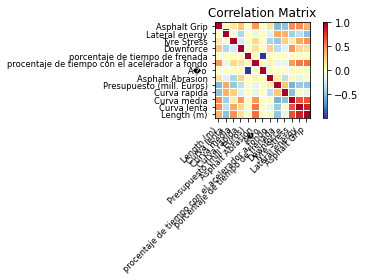

In [155]:
#Matriz de correlacciones
corr_matrix=np.corrcoef(X.T) #X.T = matriz X traspuesta
#Lo ideal es que la matriz fuese la identidad

import statsmodels.graphics.api as smg
import matplotlib.pylab as plt
smg.plot_corr(corr_matrix, xnames=lista)
plt.show()

Despues de todos los cambios anteriormente mencionados, este fue el modelo con el que nos quedamos, con el porblema de multicolinealidad medianamente resuelto, NC = 93.6.

In [156]:
lista = datos_f1[[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']]
 
X=lista
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
#print(X)
mco1 = sm.OLS(y, sm.add_constant(X)).fit()

mco1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.78
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           2.85e-21
Time:                        13:43:12   Log-Likelihood:                -189.52
No. Observations:                  63   AIC:                             393.0
Df Residuals:                      56   BIC:                             408.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.6538      5.015      2.723      0.009       3.607      23.700
Length (m)          11.4054      0.978     11.661      0.000       9.446      13.365
Curva lenta          3.0251      0.343      8.808      0.000       2.337       3.713
Curva media         -1.4984      0.549     -2.728      0.008      -2.599      -0.398
Curva rapida         0.5889      0.400      1.472      0.147      -0.212       1.390
Asphalt Grip         4.1230      1.047      3.939      0.000       2.026       6.220
Asphalt Abrasion    -3.1871      0.880     -3.623      0.001      -4.949      -1.425
==============================================================================
Omnibus:                       32.534   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.414
Skew:                           1.651   Prob(JB):                     1.14e-16
Kurtosis:                       7.130   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## MULTICOLINEALIDAD

In [157]:
#Matriz de correlacciones
corr_matrix=np.corrcoef(X.T) #X.T = matriz X traspuesta
print(corr_matrix)

#Lo ideal es que la matriz fuese la identidad

[[ 1.          0.00753052  0.13372822  0.29054151  0.36949531  0.46805826]
 [ 0.00753052  1.         -0.06111079 -0.39084757 -0.50398903 -0.12775327]
 [ 0.13372822 -0.06111079  1.         -0.24789618  0.4831656   0.22624666]
 [ 0.29054151 -0.39084757 -0.24789618  1.          0.18379252  0.17162219]
 [ 0.36949531 -0.50398903  0.4831656   0.18379252  1.          0.59086427]
 [ 0.46805826 -0.12775327  0.22624666  0.17162219  0.59086427  1.        ]]


Como se puede observar esta matriz de correlacciones mucho mas correcta que la que teniamso en un inicio, pese a contar con algunasd variables menos.

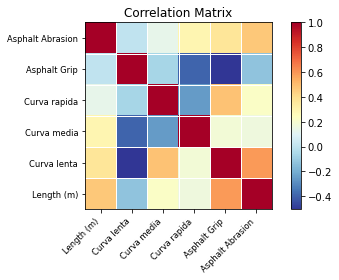

In [158]:
import statsmodels.graphics.api as smg
import matplotlib.pylab as plt
smg.plot_corr(corr_matrix, xnames=lista)
plt.show()

En cuanto a los VIFS conseguimos que estuvieran todos por debajo de los 20, menos la primera variable que siempre era el valor mas elevado.

In [159]:
import statsmodels.stats.outliers_influence as oi

#Para la primera variable
#1-(1-(R^2)) = 284 ; R = 0.9964
#Se podria decir que el tamanio dle edificio lo puedo escribir en funcion de las otas 2 variables

#Factor de inflacion de la varianza, con el for hacemos que salga  para toda las variables
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#Hay problema de multicolinealidad, si vif es mayor que 10 y si es mayor que 20, problema grave
#HAY MULTICOLINEALIDAD
vifs

[41.28812918135159,
 7.949618256746982,
 19.351884667157172,
 6.36234153030487,
 20.563114067024074,
 13.616582053542007]

## HETEROSCEDASTICIDAD

In [160]:
GQ=sms.het_goldfeldquandt(mco1.model.endog, mco1.model.exog, split=3) #Split es para que se quede con una tercera parte o lo que queramos
print('Het-Goldfelquandt', GQ)#El SPLIT 3 no se puede poner porque debe dar un valor entero. Por defecto lo hace entre 2
#El vector te da en el 2 valor el p valor, si tu alfa es menor que el p valor significa HOMOSCEDASTICIDAD

BP=sms.het_breuschpagan(mco1.resid, mco1.model.exog)
print('Het-Breuschpagan', BP)
#Este nos decía cuanto dependía nuestros residuos al cuadrado respecto de nuestras vbles. Sólo nos interesan los
#dos ultimos valores que son el estadístico experimental y el p valor. Como es mayor que nuestro alfa (0.05) hay HOMOSCEDASTICIDAD
WH=sms.het_white(mco1.resid, mco1.model.exog)
print('Het-Whithe', WH) #Igual, nos interesan sólo los dos últimos valores y significan lo mismo que en el anterior. 



Het-Goldfelquandt (22.395983859110476, 8.91817819186668e-08, 'increasing')
Het-Breuschpagan (9.74808871156059, 0.13566929814691386, 1.7085238652767456, 0.13597834675774265)
Het-Whithe (20.702735884342026, 0.4148111973097286, 1.0278618786841114, 0.453548091635767)


Hemos realizado los tests de Goldfeld-Quandt, Breusch-Pagan y White donde sólo el primero de estos nos indica que existe un problema de heteroscedasticidad (varianzas diferentes para cada individuo). Esto se puede deber a que el test de Goldfeld-Quandt es para muestras pequeñas y las demás para muestras grandes. 
En nuestro caso tenemos 63 muestras, algo que no podemos clasificar sin lugar a dudas como una muestra grande o como una muestra pequeña. Por ello ante la duda decidimos hacer el test de Glejser y si hay algún problema arreglarlo tal y como indique este test.

### Glejser

In [161]:
#Glejser se hace "a mano" a cada bleble
headers = datos_f1.columns
header_maximo=""
alpha=0.05
h_max=0.0
r_max=0.0

elements = [ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']

for indice in elements:
    print(indice)
    z=datos_f1[indice]
    z = z.astype('float64')
    for h in [-2,-1,-0.5,0.5,1,2]:
        mcoaux=sm.OLS(abs(mco1.resid),sm.add_constant((z**h))).fit()
        pval=mcoaux.pvalues[1]
        r2=mcoaux.rsquared
        #print("h: ", h, "-> pval:", pval, " R2: ", r2)
        #Nos debemos quedar con todas porque el pValor es moenr que alfa, y de ellas escogemos la de R2 más grande
        #En este caso nos da el problema el Z^2, tenemos que multiplicar mis datos (la matriz) por 1/sqrt(Z^2)
        if((pval<alpha) and (r2>r_max)):
            r_max=r2
            header_max=indice
            h_max = h

print("La variable: " + header_max + " elevado a ", h_max, " daba problema de heteroscedasticidad")
z = datos_f1[header_max].astype('float64')
mcp = sm.WLS(y, sm.add_constant(X), weights=(1/np.sqrt(z**h_max))).fit() #Regresión por cuadrados ponderados
mcp.summary()

Length (m)
Curva lenta
Curva media
Curva rapida
Asphalt Grip
Asphalt Abrasion
La variable: Asphalt Abrasion elevado a  2  daba problema de heteroscedasticidad


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            WLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     89.96
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           6.36e-27
Time:                        13:43:14   Log-Likelihood:                -181.22
No. Observations:                  63   AIC:                             376.4
Df Residuals:                      56   BIC:                             391.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.1570      3.549      3.426      0.001       5.048      19.266
Length (m)          11.9341      0.737     16.185      0.000      10.457      13.411
Curva lenta          2.7099      0.241     11.242      0.000       2.227       3.193
Curva media         -1.2861      0.478     -2.693      0.009      -2.243      -0.329
Curva rapida         0.2801      0.347      0.806      0.424      -0.416       0.976
Asphalt Grip         3.4334      0.973      3.529      0.001       1.484       5.382
Asphalt Abrasion    -2.3568      0.762     -3.094      0.003      -3.883      -0.831
==============================================================================
Omnibus:                       33.560   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.892
Skew:                           1.634   Prob(JB):                     3.68e-19
Kurtosis:                       7.654   Cond. No.                         68.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Tal y como está programado el test de Glejser hacemos lo siguiente: 
    En cada una de las variables comprobamos si hay relacion lineal entre los residuos del modelo inicial y la variable elevada a -2, -1, -0.5, 0,5, 1, 2. A continuación debemos comprobar si su pvalor es menor que el alfa (de forma que confirme problema de heteroscedasticidad) y que su R^2 sea el mínimo (ya que es con el que nos quedaremos).

Los resultados nos indicaron que la variable Asphalt Abrasion daba problemas de heteroscedasticidad por lo que decidimos estimar el modelo a través del modelo lineal generalizado multiplicando previamente la Y y las X por 1/raiz(Asphalt Abrasion^2), solucionando así los problemas de Heteroscedasticidad.

## AUTOCORRELACIÓN

In [162]:
from statsmodels.stats.stattools import durbin_watson
dw=durbin_watson(mcp.resid)
print("Durbin-Watson es ", dw)
rho= 1 - dw/2


mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho) #Es para aplicar el algoritmo Lochrane-Orcutt o Praiss-Wistein 
#Y así resolver la autocorrelación. Para a la iteración 1000 y lo hace hasta que la diferencia entre rhos sea 10^-10
#mco_autocorr.summary()
res=mco_autocorr.iterative_fit(maxiter=100 , rtol=10**(-10))
res.summary()

Durbin-Watson es  1.8402520662727382


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                          GLSAR   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     47.94
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           4.26e-20
Time:                        13:43:15   Log-Likelihood:                -186.92
No. Observations:                  62   AIC:                             387.8
Df Residuals:                      55   BIC:                             402.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.3396      5.255      2.729      0.009       3.809      24.870
Length (m)          11.3766      1.025     11.094      0.000       9.322      13.432
Curva lenta          2.9910      0.359      8.342      0.000       2.272       3.710
Curva media         -1.5114      0.581     -2.602      0.012      -2.675      -0.347
Curva rapida         0.5559      0.420      1.325      0.191      -0.285       1.397
Asphalt Grip         4.0381      1.144      3.529      0.001       1.745       6.331
Asphalt Abrasion    -3.1645      0.947     -3.340      0.002      -5.063      -1.266
==============================================================================
Omnibus:                       33.875   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.989
Skew:                           1.728   Prob(JB):                     7.04e-18
Kurtosis:                       7.316   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observamos que en el test de Durbin-Watson nos da un número de 1,777 siendo el teórico de apróximadamente (suponemos 65 muestras) dL=1.438 du= 1.767 por lo que está dentro del intervalo  1.767 < 1.777 < (4-1.767)= 2.233. 

Como está dentro por un margen bastante pequeño (de 0.01) decidimos aplicar Praiss-Wistein aunque no era totalmente necesario.

## LINEALIDAD

## Test Harvey-Collier

El primer bloque de codigo data de arreglar un problema que teniamos al intentar hacer el test de hervey_collier, ya que nos daba error en el skip a la hora de calcularlo, despues de varias horas para solucionarlo encontramos por internet esa forma de solucionarlo para un skip lo suficientemente grande como para que no diera error, le porblema es que para el mismo skip en el test (segundo bloque) nos indicaba NotANumber y con el primer bloque de codigo lo arreglamos.

Donde nos sale un pvalor = 0.03974662381399955, por lo que rechazamos H0 e indicamos que rechazamos hipotesis de linealidad.

In [163]:
from scipy import stats
skip = 19 #len(res.params)  # bug in linear_harvey_collier
rr = sms.recursive_olsresiduals(res, skip=skip, alpha=0.95, order_by=None)
stats.ttest_1samp(rr[3][skip:], 0)

Ttest_1sampResult(statistic=1.8997565698072256, pvalue=0.06418508537169498)

In [164]:
import statsmodels.stats.diagnostic as diagn #Para el test de Harvey-Collier

diagn.linear_harvey_collier(res, skip=19) # si nuestro alpha es menor que el p valor, hay linelidad, no se rechaza hipotesis nula

Ttest_1sampResult(statistic=nan, pvalue=nan)

# Normalidad de los residuos

- Jarque-Bera: Test de hipótesis que contrasta si los datos de la muestra tienen el coeficiente de simetría y la curtósis de una distribución normal.
- $\chi^2$ (p-valor): p-valor del Test de Jaque-Bera.
- Skew: Coeficiente de Simetría de pearson de los residuos.
- Kurtosis: Coeficiente de apuntamiento de los residuos.
- Komogorov-Smirnov: Test de Hipótesis para contrastar si una muestra proviene de una distribución (en este caso normal).

In [165]:
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
for i in range(4):
    print(name[i], test[i]) # para rechazar hipotesis nula de normalidad, tine que ser el pvlor mas cihco que 0.05 nuestro alpha
                            # para que sea simetrica tiene que ser 0 la skew
                            # para que la kurtosis sea normal tiene que ser de 4, es de 6 a asi que bueno

Jarque-Bera 76.76212656414955
Chi^2 two-tail prob. 2.1444504065430605e-17
Skew 1.6799857401403864
Kurtosis 7.23713423592888


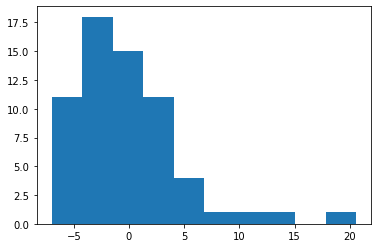

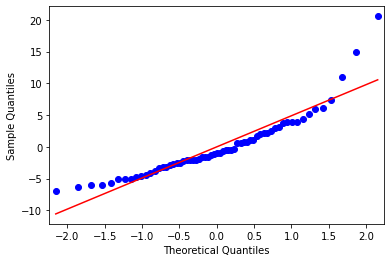

In [166]:
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

pyplot.hist(res.resid)
pyplot.show()
qqplot(res.resid, line='s')
pyplot.show()  # si los datos fueran normales estarian encima de mi linea roja, a si que no esta mal del todo

En cuanto a la normalidad de los residuos, podemos observar en la primera grafica como se semeja vagamente a una distribucion normal y en cuanto a la segunda grafica como la la mayoria de valores se encuentran por debajo de la linea roja.

Con tod esto se puede suponer lo que demuestra justo debajo el test de Kurtosis, rechazamos hipotesis nula de normalidad de los residuos.

In [167]:
import statsmodels.stats.diagnostic as diag

diag.kstest_normal(res.resid)

(0.13583628079337862, 0.00895822888898061)

## Predicciones F1

Length (m) = 6174

Curva lenta = 2

Curva media = 2

Curva rapida = 4

log(ag) = log(3) = 0.47712125472

Asphalt Abrasion = 2

In [179]:
tiempo = res.params[0] + res.params[1]*6174 + res.params[2]*2 + res.params[3]*2 + res.params[4]*4 + res.params[5]*3 + res.params[6]*2

print (tiempo , " y tenia que haber sido " , 87653)
print ( "Le ha faltado", 87653-tiempo)

70264.69415331222  y tenia que haber sido  87653
Le ha faltado 17388.305846687785


Length (m) = 5380

Curva lenta = 1

Curva media = 5

Curva rapida = 5

log(ag) = log(3) = 0.47712125472

Asphalt Abrasion = 4

In [183]:
tiempo = res.params[0] + res.params[1]*5380 + res.params[2]*1 + res.params[3]*5 + res.params[4]*5 + res.params[5]*3 + res.params[6]*4

print (tiempo , " y tenia que haber sido " , 81478)
print ( "Le ha faltado", 81478-tiempo)

61218.342144718095  y tenia que haber sido  81478
Le ha faltado 20259.657855281905


Length (m) = 5338

Curva lenta = 4

Curva media = 5

Curva rapida = 3

ag = 3

Asphalt Abrasion = 4

In [182]:
tiempo = res.params[0] + res.params[1]*5338 + res.params[2]*4 + res.params[3]*5 + res.params[4]*3 + res.params[5]*3 + res.params[6]*4

print (tiempo , " y tenia que haber sido " , 83196)
print ( "Le ha faltado", 83196-tiempo)

60748.38450850479  y tenia que haber sido  83196
Le ha faltado 22447.615491495213
